# Developing scripts for data preparation

In [22]:
import numpy as np

import xarray as xr

from pathlib import Path
from src import utils
from src.prepare_data import prepare_dataset, _open

In [23]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [24]:
from src import prepare_data

### Cluster

In [4]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.54.36:8787/status


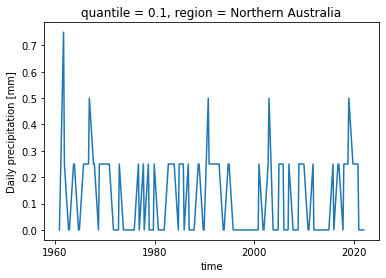

In [27]:
xr.open_zarr(
    "../../data/processed/AGCD.annual.3-months_under_p10_1985-2014.precip_Aus_NRM.zarr"
)["precip"].isel(region=0).plot()

In [57]:
%%time

config_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/config/prepare_data"
)
save_dir = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/processed"
)
test = prepare_dataset(
    config=f"{config_dir}/CanESM5_ctrl.precip.yml", save_dir=save_dir, save=False
)

CPU times: user 5.57 s, sys: 18 ms, total: 5.59 s
Wall time: 5.61 s


In [58]:
ds = test[0]

In [59]:
ds

<xarray.Dataset>
Dimensions:  (time: 1051, lon: 144, lat: 90)
Coordinates:
  * time     (time) object 5550-12-01 00:00:00 ... 6600-12-01 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
    zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
    area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1051, 10, 12), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Add new open method

In [42]:
import dask

import glob

DATA_DIR = "../../data/raw/"


def _cmip6(model, experiment, variant_id, grid, variables, realm, members, version):
    """
    Open CMIP6 variables from specified realm

    Can specify version='latest' but this is slower as it has to search each
    directory for the latest version
    """

    def _cmip_files(m, v):
        # Would be much better just to name the datasets by the experiment, but too much
        # effort to change now
        if experiment == "historical":
            dataset = f"{model}_hist"
        elif experiment == "piControl":
            dataset = f"{model}_ctrl"
        else:
            raise ValueError("I'm not sure I can open this experiment type")

        path = f"{DATA_DIR}/{dataset}/r{m}{variant_id}/{realm}/{v}/{grid}"
        if version == "latest":
            versions = sorted(glob.glob(f"{path}/v????????"))
            if len(versions) == 0:
                raise ValueError(f"No versions found for {path}")
            else:
                path = versions[-1]
        else:
            path = f"{path}/{version}"
        file_pattern = f"{v}_{realm}_{model}_{experiment}_r{m}{variant_id}_{grid}_*.nc"
        files = sorted(glob.glob(f"{path}/{file_pattern}"))
        if len(files) == 0:
            raise ValueError(f"No files found for {path}/{file_pattern}")
        else:
            return files

    @dask.delayed
    def _open_cmip_delayed(m, v):
        files = _cmip_files(m, v)
        return xr.concat(
            [xr.open_dataset(f, chunks={}, use_cftime=True) for f in files],
            dim="time",
        )[v]

    def _open_cmip(m, v):
        var_data = _open_cmip_delayed(m, v).data
        return dask.array.from_delayed(var_data, d0.shape, d0.dtype)

    ds = []
    for v in variables:
        f0 = _cmip_files(members[0], v)
        d0 = xr.concat(
            [xr.open_dataset(f, chunks={}, use_cftime=True) for f in f0], dim="time"
        )[v]

        delayed = dask.array.stack([_open_cmip(m, v) for m in members], axis=0)

        ds.append(
            xr.DataArray(
                delayed,
                dims=["member", *d0.dims],
                coords={
                    "member": members,
                    **d0.coords,
                },
                attrs=d0.attrs,
            ).to_dataset(name=v)
        )

    return xr.merge(ds).compute()


def CanESM5_hist(variables, realm, preprocess):
    """Open CanESM5 historical variables from specified realm"""
    ds = _cmip6(
        "CanESM5",
        "historical",
        "i1p2f1",
        "gn",
        variables,
        realm,
        range(1, 40 + 1),
        "v20190429",
    )
    ### Add cell area
    if realm == "Omon":
        file = (
            f"{DATA_DIR}/CanESM5_hist/r1i1p2f1/Ofx/areacello/gn/v20190429/"
            f"areacello_Ofx_CanESM5_historical_r1i1p2f1_{grid}.nc"
        )
    elif realm == "Amon":
        file = (
            f"{DATA_DIR}/CanESM5_hist/r1i1p2f1/fx/areacella/gn/v20190429/"
            f"areacella_fx_CanESM5_historical_r1i1p2f1_gn.nc"
        )
    else:
        raise ValueError(f"I don't know where to find the area for realm: {realm}")
    area = xr.open_dataset(file, chunks={})
    ds = ds.assign_coords(area)

    if preprocess is not None:
        return preprocess(ds)
    else:
        return ds


def CanESM5_ctrl(variables, realm, preprocess):
    """Open CanESM5 piControl variables from specified realm"""
    ds = _cmip6(
        "CanESM5", "piControl", "i1p2f1", "gn", variables, realm, [1], "v20190429"
    ).sel(member=1, drop=True)
    ### Add cell area
    if realm == "Omon":
        file = (
            f"{DATA_DIR}/CanESM5_hist/r1i1p2f1/Ofx/areacello/gn/v20190429/"
            f"areacello_Ofx_CanESM5_historical_r1i1p2f1_{grid}.nc"
        )
    elif realm == "Amon":
        file = (
            f"{DATA_DIR}/CanESM5_hist/r1i1p2f1/fx/areacella/gn/v20190429/"
            f"areacella_fx_CanESM5_historical_r1i1p2f1_gn.nc"
        )
    else:
        raise ValueError(f"I don't know where to find the area for realm: {realm}")
    area = xr.open_dataset(file, chunks={})
    ds = ds.assign_coords(area)

    if preprocess is not None:
        return preprocess(ds)
    else:
        return ds

In [43]:
CanESM5_ctrl(["pr"], "Amon", None)

<xarray.Dataset>
Dimensions:    (time: 12612, lat: 64, lon: 128, bnds: 2)
Coordinates:
  * time       (time) object 5550-01-16 12:00:00 ... 6600-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    areacella  (lat, lon) float32 dask.array<chunksize=(64, 128), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(612, 64, 128), meta=np.ndarray>

In [45]:
test = xr.Dataset(
    data_vars={"d": ("lead", [1, 2, 3, 4])}, coords={"lead": [0, 1, 2, 3]}
)
test["lead"].attrs["units"] = "days"

In [47]:
test.to_zarr("delete.zarr")

In [52]:
xr.open_zarr("delete.zarr", decode_timedelta=False)

<xarray.Dataset>
Dimensions:  (lead: 4)
Coordinates:
  * lead     (lead) int64 0 1 2 3
Data variables:
    d        (lead) int64 dask.array<chunksize=(4,), meta=np.ndarray>

In [14]:
a = utils.anomalise(ds, clim_period=["1991-01-01", "2020-12-31"], frequency="month")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 62 times more chunks
  return self.array[key]


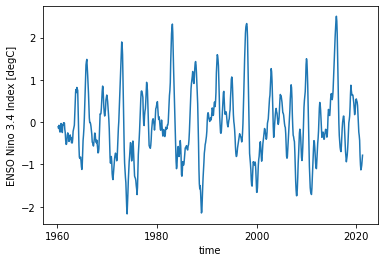

In [17]:
a["nino34"].plot()

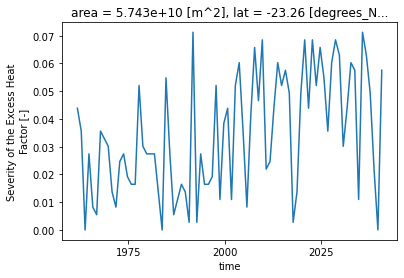

In [444]:
ds["EHF_severity"].isel(lon=10, lat=10, member=0).plot()

In [396]:
lead = 9

hcst_ts = (
    hcst["EHF_severity"]
    .isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=slice("1991", "2020"))
    .compute()
)
obsv_ts = obsv["EHF_severity"].sel(time=hcst_ts.time).compute()

# _ = hcst_ts.mean("member").plot.line(x="time", add_legend=False)
# obsv_ts.plot(color="k")

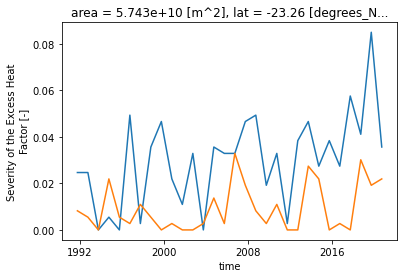

In [397]:
hcst_ts.isel(member=0, lon=10, lat=10).plot()
obsv_ts.isel(lon=10, lat=10).plot()

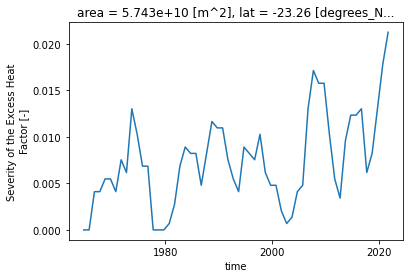

In [356]:
test = xr.open_zarr("../../data/processed/AGCD.4-year.days_over_1.EHF_sev_Aus.zarr")[
    "EHF_severity"
]

test.isel(lat=10, lon=10).plot()

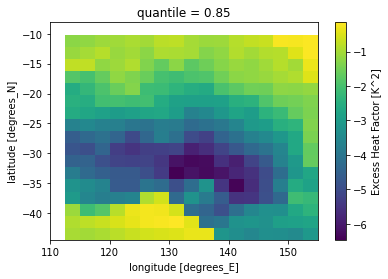

In [343]:
p = utils.calculate_percentile_thresholds(
    test, percentile=0.85, percentile_period=["1958-01-01", "2011-12-31"]
)
p.plot()

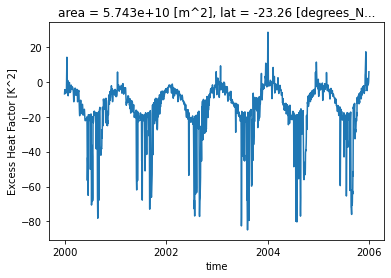

In [347]:
test.isel(lat=10, lon=10).sel(time=slice("2000", "2005")).plot()

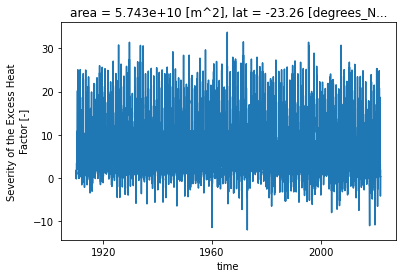

In [335]:
obsv["EHF_severity"].isel(lat=10, lon=10).plot()

In [349]:
b = utils.coarsen(obsv > 1, window_size=365, start_points=["1960-11-01"], dim="time")

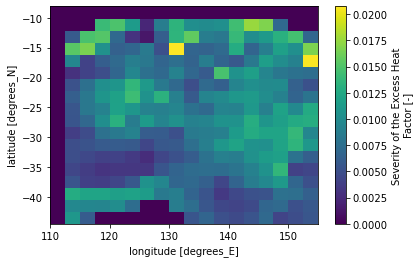

In [350]:
utils.keep_period(b, period=["1991-01-01", "2020-12-31"]).mean("time")[
    "EHF_severity"
].plot()

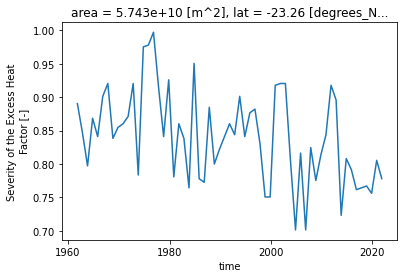

In [322]:
b["EHF_severity"].isel(lat=10, lon=10).plot()

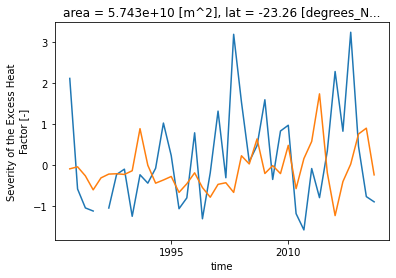

In [298]:
hcst_ts.isel(member=0, lat=10, lon=10).plot()
obsv_ts.isel(lat=10, lon=10).plot()

In [175]:
ds = xr.open_zarr("../../data/processed/AGCD.daily.full.EHF_Aus.zarr")

In [178]:
ds["EHF"]

<xarray.DataArray 'EHF' (time: 40880, lat: 18, lon: 18)>
dask.array<open_dataset-03910b1bda02fd73fad54e78633b5b17EHF, shape=(40880, 18, 18), dtype=float64, chunksize=(40880, 18, 18), chunktype=numpy.ndarray>
Coordinates:
    area      (lat, lon) float32 dask.array<chunksize=(18, 18), meta=np.ndarray>
  * lat       (lat) float64 -43.48 -41.46 -39.44 -37.42 ... -13.15 -11.12 -9.101
  * lon       (lon) float64 111.2 113.8 116.2 118.8 ... 146.2 148.8 151.2 153.8
    quantile  float64 ...
  * time      (time) object 1910-01-01 00:00:00 ... 2021-12-31 00:00:00
    zsurf     (lat, lon) float32 dask.array<chunksize=(18, 18), meta=np.ndarray>
Attributes:
    analysis_time:              2018-08-16 23:47:23 UTC
    analysis_version_number:    2.01
    cell_methods:               time: minimum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Excess Heat Factor
    source:                     Interpolated surface observations
    standard_name:              excess_heat_factor
    units:                      K^2

In [172]:
calculate_EHF(ds, "data/processed/AGCD.daily.p95_1971-2000.t_ref_Aus.zarr")

<xarray.Dataset>
Dimensions:   (lat: 18, lon: 18, time: 40880)
Coordinates:
    area      (lat, lon) float32 4.536e+10 4.536e+10 ... 6.173e+10 6.173e+10
  * lat       (lat) float64 -43.48 -41.46 -39.44 -37.42 ... -13.15 -11.12 -9.101
  * lon       (lon) float64 111.2 113.8 116.2 118.8 ... 146.2 148.8 151.2 153.8
  * time      (time) object 1910-01-01 00:00:00 ... 2021-12-31 00:00:00
    zsurf     (lat, lon) float32 0.0 0.0 0.0 0.0 ... 264.9 380.6 46.86 0.5029
    quantile  float64 ...
Data variables:
    EHF       (time, lat, lon) float64 dask.array<chunksize=(40880, 18, 18), meta=np.ndarray>

In [5]:
ds = test[0]

In [16]:
anom = utils.anomalise(ds["precip"], clim_period=["1991-01-01", "2020-12-31"])

In [ ]:
xhist.histogram()

In [25]:
ds["precip"].max().values

array(0.00688461, dtype=float32)

In [21]:
from xhistogram import xarray as xhist

xhist.histogram(ds["precip"]

<xarray.DataArray 'precip' (init: 40, lead: 3650, ensemble: 96, lat: 18, lon: 18)>
dask.array<concatenate, shape=(40, 3650, 96, 18, 18), dtype=float32, chunksize=(1, 28, 96, 18, 18), chunktype=numpy.ndarray>
Coordinates:
    area        (lat, lon) float32 dask.array<chunksize=(18, 18), meta=np.ndarray>
    average_DT  (lead) timedelta64[ns] 1 days 1 days 1 days ... 1 days 1 days
    average_T1  (lead) datetime64[ns] 1981-11-03 1981-11-04 ... 1991-11-02
    average_T2  (lead) datetime64[ns] 1981-11-04 1981-11-05 ... 1991-11-03
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * lat         (lat) float64 -43.48 -41.46 -39.44 ... -13.15 -11.12 -9.101
    level       float32 1e+03
  * lon         (lon) float64 111.2 113.8 116.2 118.8 ... 148.8 151.2 153.8
  * lead        (lead) int64 0 1 2 3 4 5 6 ... 3644 3645 3646 3647 3648 3649
    zsurf       (lat, lon) float32 dask.array<chunksize=(18, 18), meta=np.ndarray>
  * init        (init) object 1981-11-01 12:00:00 ... 2020-11-01 12:00:00
    time        (init, lead) object 1981-11-01 12:00:00 ... 2030-10-31 12:00:00
Attributes:
    cell_methods:   time: mean
    interp_method:  conserve_order1
    long_name:      Total precipitation rate
    time_avg_info:  average_T1,average_T2,average_DT
    units:          kg/m2/s

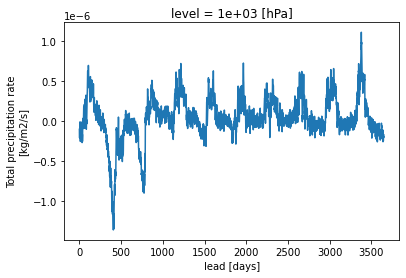

In [18]:
anom.mean(["init", "lat", "lon"]).mean("ensemble").plot()

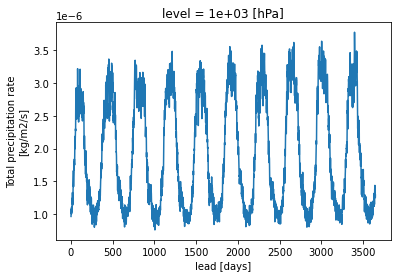

In [15]:
ds["precip"].mean(["init", "lat", "lon"]).std("ensemble").plot()

In [153]:
ds1 = xr.open_zarr(
    "../../data/processed/CanESM5_hist.annual.3-months_under_p10_1985-2014.precip_Aus_NRM.zarr"
)

In [154]:
ds1.time

<xarray.DataArray 'time' (time: 54)>
array([cftime.DatetimeJulian(1961, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1962, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1963, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1964, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1965, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1966, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1967, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1968, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1969, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1970, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1971, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1972, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1973, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1974, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1975, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1976, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1977, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1978, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1979, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1980, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1981, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1982, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1983, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1984, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1985, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1986, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1987, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1988, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1989, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1990, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1991, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1992, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1993, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1994, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1995, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1996, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1997, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1998, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1999, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2000, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2001, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2002, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2003, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2004, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2005, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2006, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2007, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2008, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2009, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2010, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2011, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2012, 2, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2013, 2, 1, 0, 0, 0, 0, has_year_z

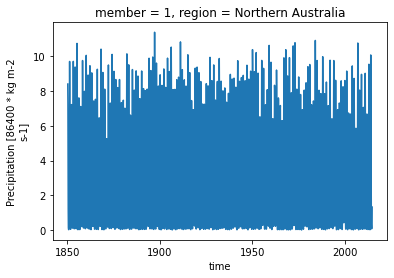

In [148]:
ds1["precip"].isel(member=0, region=0).plot()

In [103]:
ds2 = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.3-months_under_p10_1991-2020.precip_Aus_NRM.zarr"
)

In [105]:
ds2.time.values

array([[cftime.DatetimeJulian(1982, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1983, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1984, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1985, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1986, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1987, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1988, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1989, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1990, 12, 1, 0, 0, 0, 0, has_year_zero=False)],
       [cftime.DatetimeJulian(1983, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1984, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1985, 12, 1, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(1986, 12, 1, 0, 0, 0, 0, has_year_zero=False)

In [44]:
hcst = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.days_over_p90_1991-2020.ffdi_Aus_NRM.zarr"
)
obsv = xr.open_zarr(
    "../../data/processed/JRA55.annual.days_over_p90_1991-2020.ffdi_Aus_NRM.zarr"
)

In [74]:
lead = 2
region = 0
period = slice("1991-01-01", "2020-12-31")

hcst_ts = (
    hcst["FFDI"]
    .isel(lead=lead, region=region)
    .mean("member")
    .swap_dims({"init": "time"})
    .sel(time=period)
)
obsv_ts = obsv["FFDI"].isel(region=region).sel(time=hcst_ts.time.values)

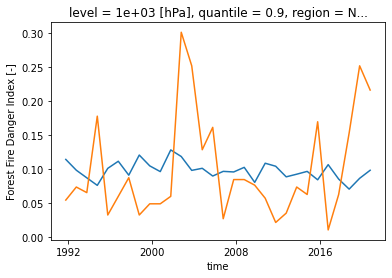

In [75]:
hcst_ts.plot()
obsv_ts.plot()

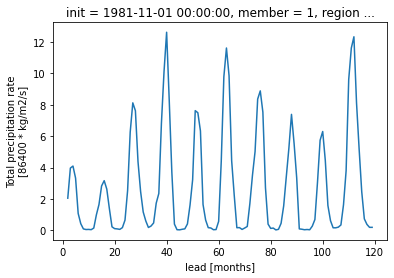

In [32]:
ds["precip"].isel(member=0, region=0, init=0).plot()

In [7]:
ds = xr.open_zarr("../../data/processed/CAFEf6.daily.full.ffdi_Aus_NRM.zarr")

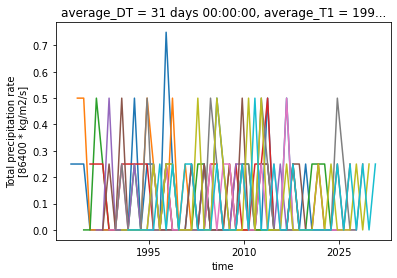

In [60]:
for lead in ds.lead:
    a = ds["precip"].isel(region=0, member=0).sel(lead=lead).swap_dims({"init": "time"})
    a.plot()

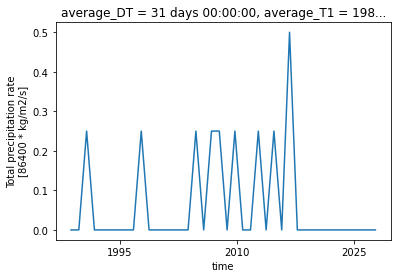

In [61]:
ds["precip"].isel(region=0, member=0, lead=6).swap_dims({"init": "time"}).plot()

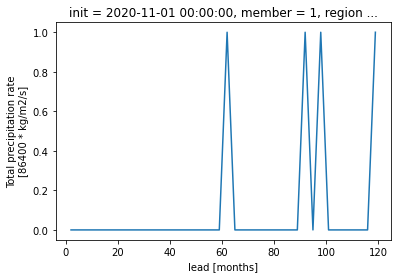

In [21]:
a["precip"].isel(member=0, region=0, init=-1).plot()

In [82]:
ds = xr.open_zarr("../../data/processed/CAFEf6.daily.full.ffdi_Aus_NRM.zarr")

In [83]:
ds

<xarray.Dataset>
Dimensions:     (lead: 3650, init: 40, member: 96, region: 5)
Coordinates:
    average_DT  (lead) timedelta64[ns] dask.array<chunksize=(3650,), meta=np.ndarray>
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(3650,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(3650,), meta=np.ndarray>
  * init        (init) object 1981-11-01 00:00:00 ... 2020-11-01 00:00:00
  * lead        (lead) timedelta64[ns] 0 days 1 days ... 3648 days 3649 days
    level       float32 ...
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * region      (region) <U18 'Northern Australia' 'Rangelands' ... 'Australia'
    time        (init, lead) object dask.array<chunksize=(20, 1825), meta=np.ndarray>
Data variables:
    ffdi        (init, lead, member, region) float32 dask.array<chunksize=(1, 28, 96, 5), meta=np.ndarray>

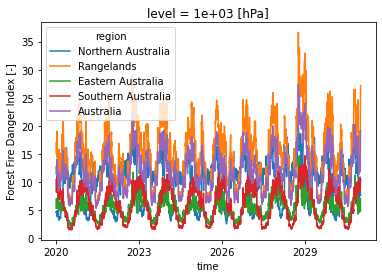

In [81]:
b = ds["FFDI"].mean("member").sel(time=slice("2020", "2030"))
_ = b.plot.line(x="time")

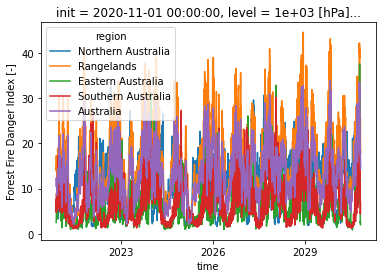

In [24]:
a = ds["FFDI"].isel(member=0, init=-1).swap_dims({"lead": "time"})
_ = a.plot.line(x="time")

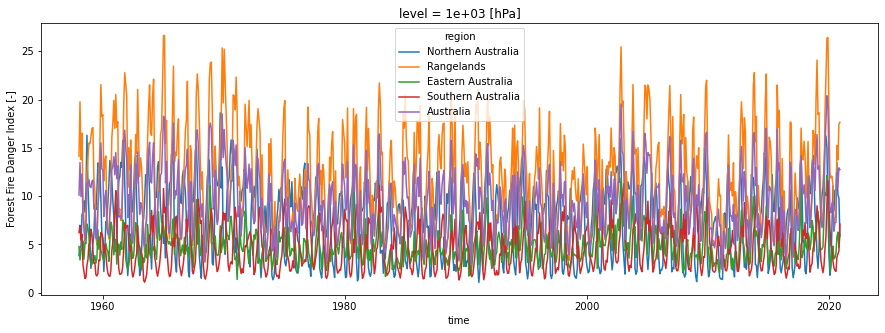

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
ds["FFDI"].coarsen(time=30, boundary="trim").mean().plot.line(x="time")

In [26]:
f6 = xr.open_zarr("../../data/processed/CAFEf6.daily.full.t_ref_max_Aus_NRM.zarr")
agcd = xr.open_zarr("../../data/processed/AGCD.daily.full.t_ref_max_Aus_NRM.zarr")

# test = utils.drop_Feb_29(test)

In [27]:
from src import plot

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [41]:
f6_days_over_p90 = utils.coarsen(
    over_percentile_threshold(f6, 0.9, ["1991-01-01", "2020-12-31"]).compute(),
    window_size=4 * 365,
    dim="lead",
)

agcd_days_over_p90 = utils.coarsen(
    over_percentile_threshold(agcd, 0.9, ["1991-01-01", "2020-12-31"]).compute(),
    window_size=4 * 365,
    dim="time",
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 62 times more chunks
  return self.array[key]


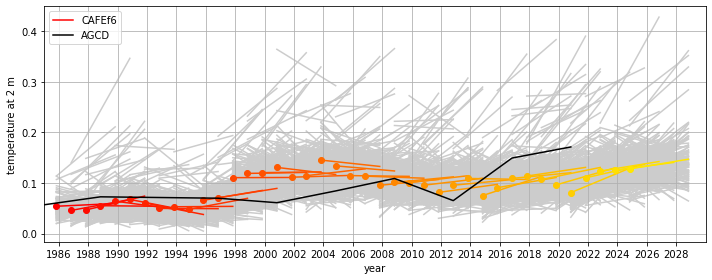

In [42]:
region = "Australia"

_ = plot.hindcasts(
    {"CAFEf6": f6_days_over_p90.sel(region=region)},
    {"AGCD": agcd_days_over_p90.sel(region=region)},
)

# Make sure units are matched

In [103]:
a = xr.open_zarr("../../data/processed/EC_Earth3.annual.full.t_ref_global.zarr")

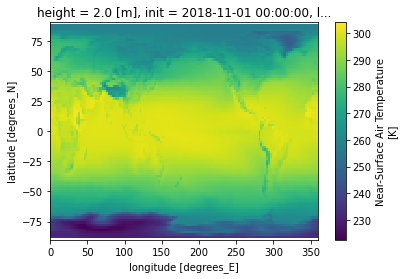

In [104]:
a["t_ref"].isel(init=-1, lead=0, member=0).plot()

In [99]:
b = xr.open_zarr("../../data/processed/JRA55.annual-Jan.full.t_ref_global.zarr")

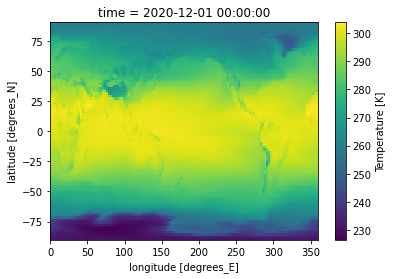

In [100]:
b["t_ref"].isel(time=-1).plot()

In [102]:
region_1 = [140, 215, 25, 45]
region_2 = [170, 270, -10, 10]
region_3 = [150, 200, -50, -15]

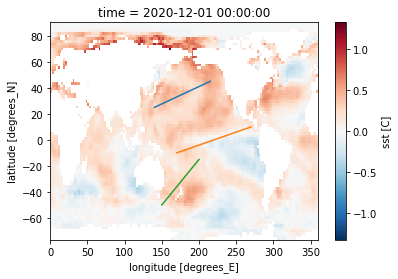

In [105]:
sst_anom["sst"].isel(time=-1).plot()
plt.plot([region_1[0], region_1[1]], [region_1[2], region_1[3]])
plt.plot([region_2[0], region_2[1]], [region_2[2], region_2[3]])
plt.plot([region_3[0], region_3[1]], [region_3[2], region_3[3]])

In [87]:
test = xr.open_zarr(f"{save_dir}/EC_Earth3.t_ref.zarr")

CPU times: user 294 ms, sys: 72.5 ms, total: 366 ms
Wall time: 1.55 s


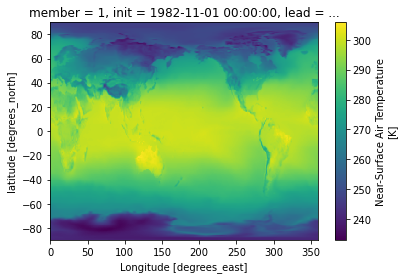

In [84]:
%%time
test["tas"].isel(member=0, init=1, lead=0).plot()

### Process some data

In [4]:
PROJECT_DIR = Path("/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/")

config_dir = PROJECT_DIR / "data/config"
save_dir = PROJECT_DIR / "data/processed"

In [5]:
%%time
prepare_dataset(config_dir / "EN422.yml", save_dir)

CPU times: user 3min 5s, sys: 35.3 s, total: 3min 41s
Wall time: 2min 28s


## Check the data

In [25]:
test = xr.open_zarr("../../data/processed/EN422.annual-Jan.anom_1991-2020.ohc300.zarr")

In [57]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )
        #         all_null = test_rolling.isnull().all(dim=set(test_rolling.dims) - set([dim]))
        #         dss.append(rolling_mean.where(all_null == False, drop=True))
        dss.append(test_rolling.dropna(dim=dim, how="all"))
    return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
test_coarsen = utils.coarsen(
    test,
    window_size=4,
    dim="lead",
)
test_rolling = utils.rolling_mean(
    test,
    window_size=4,
    dim="lead",
)

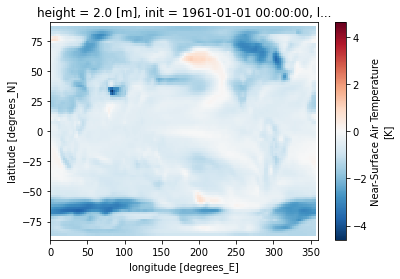

In [21]:
test_coarsen["t_ref"].isel(init=0, lead=1, member=0).plot()

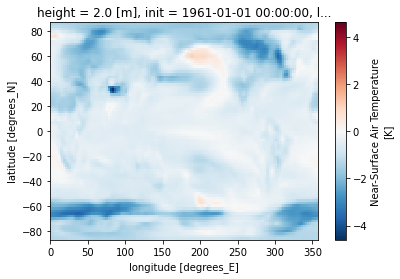

In [24]:
test_rolling["t_ref"].isel(init=0, lead=4, member=0).plot()

In [120]:
test = utils.calculate_amv(sst_anom)

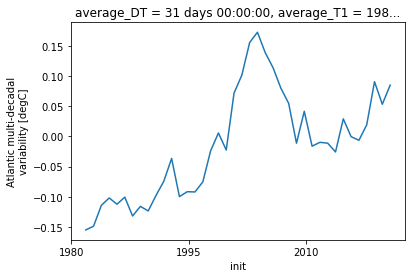

In [124]:
test["amv"].isel(lead=0).mean("member").plot()

In [296]:
ds = "CAFEf6"
var = "ohc300"
test = xr.open_zarr(PROJECT_DIR / f"data/processed/{ds}.{var}.zarr")
test

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, member: 40, time: 55)
Coordinates:
    area     (lat, lon) float64 dask.array<chunksize=(90, 144), meta=np.ndarray>
    height   float64 ...
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) object 1960-12-01 00:00:00 ... 2014-12-01 00:00:00
Data variables:
    t_ref    (member, time, lat, lon) float32 dask.array<chunksize=(40, 55, 90, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

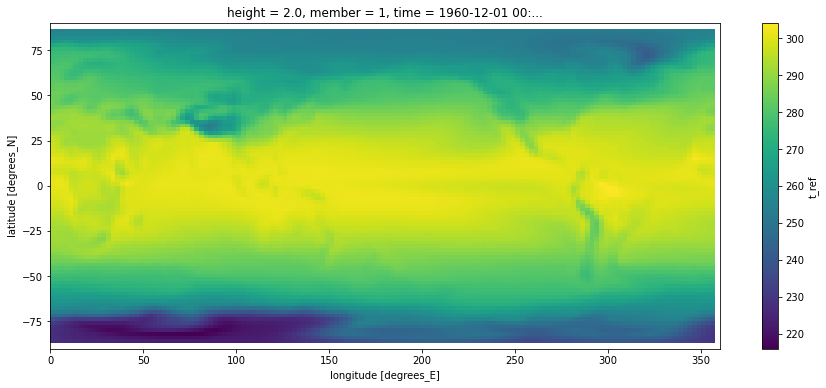

In [297]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
test[var].isel(time=0, member=0).plot()

# Getting rolling working

In [1]:
import xarray as xr
from src import utils

test = xr.open_zarr("../../data/processed/CAFE60v1.annual.anom_1991-2020.t_ref.zarr")

In [6]:
def rolling_mean(ds, window_size, start_points=None, dim="time"):
    """
    Apply a rolling mean to the data, applying 'max' to all relevant coords and optionally starting
    at a particular time point in the array

    Parameters
    ----------
    ds : xarray Dataset
        The dataset to apply the rolling mean to
    start_points : str or list of str
        Value(s) of coordinate `dim` to start the coarsening from. If these fall
        outside the range of the coordinate, coarsening starts at the beginning
        of the array
    dim : str, optional
        The name of the dimension to coarsen along
    """
    if start_points is None:
        start_points = [None]

    dss = []
    for start_point in start_points:
        rolling_mean = (
            ds.sel({dim: slice(start_point, None)})
            .rolling(
                {dim: window_size},
                min_periods=window_size,
                center=False,
            )
            .mean()
        )

        return rolling_mean
#         dss.append(rolling_mean.where(rolling_mean.notnull(), drop=True))
#     return xr.concat(dss, dim=dim).sortby(dim)

In [8]:
r = rolling_mean(test, window_size=4)

In [12]:
r.where(r.notnull())

<xarray.Dataset>
Dimensions:  (time: 120, member: 96, lat: 90, lon: 144, latb: 91, lonb: 145)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * member   (member) int32 1 2 3 4 5 6 7 8 9 10 ... 88 89 90 91 92 93 94 95 96
  * time     (time) object 1960-12-01 00:00:00 ... 2020-10-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(10, 12), meta=np.ndarray>
  * latb     (latb) float64 -90.0 -88.99 -86.97 -84.94 ... 86.97 88.99 90.0
  * lonb     (lonb) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Data variables:
    t_ref    (time, member, lat, lon) float64 dask.array<chunksize=(120, 96, 10, 12), meta=np.ndarray>

In [22]:
import xarray as xr
from src import utils
test  = xr.open_zarr("../../data/raw/HadISST/ocean_month.zarr", use_cftime=True).isel(latitude=90, longitude=180)

In [56]:
test_annual = utils.coarsen(test, window_size=12, start_points=["1960-01-01", "1960-11-01"]).compute()
test_4year = rolling_mean(test, window_size=4*12, start_points=["1960-01-01"]).isel(time=slice(None,None,12)).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [60]:
test = xr.open_zarr("../../data/processed/HadISST.annual-Jan.anom_1985-2014.sst.zarr")

In [62]:
rolling_mean(test, window_size=4)

<xarray.Dataset>
Dimensions:  (time: 58, lat: 83, lon: 144)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
  * lat      (lat) float64 -75.84 -73.82 -71.8 -69.78 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 1963-12-01 00:00:00 ... 2020-12-01 00:00:00
    zsurf    (lat, lon) float32 dask.array<chunksize=(3, 12), meta=np.ndarray>
Data variables:
    sst      (time, lat, lon) float64 dask.array<chunksize=(58, 3, 12), meta=np.ndarray>

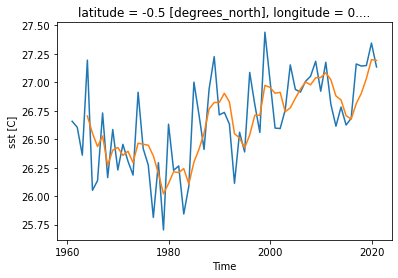

In [44]:
test_annual["sst"].plot()
test_4year["sst"].plot()

In [49]:
test_annual_anom = utils.anomalise(test_annual, ["1991-01-01", "2020-12-31"])

In [50]:
test_4annual_anom = rolling_mean(test_annual_anom, window_size=4)

In [55]:
test_4annual_anom

<xarray.Dataset>
Dimensions:    (time: 58, nv: 2)
Coordinates:
    latitude   float32 -0.5
    longitude  float32 0.5
  * time       (time) object 1963-12-16 12:00:00 ... 2020-12-16 12:00:00
Dimensions without coordinates: nv
Data variables:
    sst        (time) float32 -0.1737 -0.3251 -0.4424 ... 0.1554 0.3207 0.3141
    time_bnds  (time, nv) float32 -1.607e+04 -1.607e+04 ... 4.748e+03 4.749e+03

In [51]:
test_4year_anom = utils.anomalise(test_4year, ["1991-01-01", "2020-12-31"])

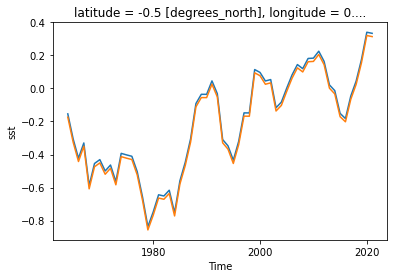

In [52]:
test_4year_anom["sst"].plot()
test_4annual_anom["sst"].plot()